In [22]:
import os
import pandas as pd
from pathlib import Path
import pandas as pd
import pandas as pd
import numpy as np
import re
from scipy.stats import gmean
from scipy import stats
import matplotlib.pyplot as plt
# Sets the path to the parent directory of RR classes
os.chdir(Path("/Users/vikrambahadur/reproducible_research/RRcourse2024"))

# Import data from the O*NET database, at ISCO-08 occupation level.
# The original data uses a version of SOC classification, but the data we load here
# are already cross-walked to ISCO-08 using: https://ibs.org.pl/en/resources/occupation-classifications-crosswalks-from-onet-soc-to-isco/

# The O*NET database contains information for occupations in the USA, including
# the tasks and activities typically associated with a specific occupation.
task_data = pd.read_csv(Path("Data/onet_tasks.csv"))
# isco08 variable is for occupation codes
# the t_* variables are specific tasks conducted on the job

# read employment data from Eurostat
# These datasets include quarterly information on the number of workers in specific
# 1-digit ISCO occupation categories. (Check here for details: https://www.ilo.org/public/english/bureau/stat/isco/isco08/)
data_set_map = {"isco1": pd.read_excel(Path("Data/Eurostat_employment_isco.xlsx", sheet_name="ISCO1")),
"isco2": pd.read_excel(Path("Data/Eurostat_employment_isco.xlsx", sheet_name="ISCO2")),
"isco3": pd.read_excel(Path("Data/Eurostat_employment_isco.xlsx", sheet_name="ISCO3")),
"isco4": pd.read_excel(Path("Data/Eurostat_employment_isco.xlsx", sheet_name="ISCO4")),
"isco5": pd.read_excel(Path("Data/Eurostat_employment_isco.xlsx", sheet_name="ISCO5")),
"isco6": pd.read_excel(Path("Data/Eurostat_employment_isco.xlsx", sheet_name="ISCO6")),
"isco7": pd.read_excel(Path("Data/Eurostat_employment_isco.xlsx", sheet_name="ISCO7")),
"isco8": pd.read_excel(Path("Data/Eurostat_employment_isco.xlsx", sheet_name="ISCO8")),
"isco9": pd.read_excel(Path("Data/Eurostat_employment_isco.xlsx", sheet_name="ISCO9"))}

#data_set_map = {"isco1":isco1, "isco2":isco2, "isco3":isco3, "isco4":isco4, "isco5":isco5, "isco6":isco6, "isco7":isco7, "isco8":isco8, "isco9":isco9}


In [23]:

# Let's merge all these datasets. We'll need a column that stores the occupation categories:
for index, (key, value) in enumerate(data_set_map.items()):
    value['ISCO']= index+1

# and this gives us one large file with employment in all occupations.
all_data = pd.concat(data_set_map.values(), ignore_index=True)

def add_country_total_and_share(all_data, data_set_map, country_name):
    total_country=0
    for k,v in data_set_map.items():
        # This will calculate worker totals in each of the chosen countries.
        total_country += v[country_name]
    # We have 9 occupations and the same time range for each, so we can add the totals by
    # adding a vector that is 9 times the previously calculated totals
    all_data["total_"+country_name] = pd.concat([total_country]*9, ignore_index=True)
    # And this will give us shares of each occupation among all workers in a period-country
    #all_data['share_Belgium'] = all_data['Belgium'] / all_data['total_Belgium']
    all_data["share_"+country_name] = all_data[country_name] / all_data["total_"+country_name]

add_country_total_and_share(all_data, data_set_map, "Belgium")
add_country_total_and_share(all_data, data_set_map, "Spain")
add_country_total_and_share(all_data, data_set_map, "Poland")


In [24]:
# Now let's look at the task data. We want the first digit of the ISCO variable only

task_data["isco08_1dig"] = task_data["isco08"].astype(str).str[:1].astype(int)

# And we'll calculate the mean task values at a 1-digit level 
# (more on what these tasks are below)
aggdata = task_data.groupby(["isco08_1dig"]).mean()
aggdata = aggdata.drop(columns=["isco08"])

# We'll be interested in tracking the intensity of Non-routine cognitive analytical tasks
# Using a framework reminiscent of the work by David Autor.

#These are the ones we're interested in:
# Non-routine cognitive analytical
# 4.A.2.a.4 Analyzing Data or Information
# 4.A.2.b.2 Thinking Creatively
# 4.A.4.a.1 Interpreting the Meaning of Information for Others

#Let's combine the data.
combined = pd.merge(all_data, aggdata, left_on='ISCO', right_on='isco08_1dig', how='left')
# Traditionally, the first step is to standardise the task values using weights 
# defined by share of occupations in the labour force. This should be done separately
# for each country. Standardisation -> getting the mean to 0 and std. dev. to 1.
# Let's do this for each of the variables that interests us:



In [25]:
def standarlized(data_set, col_name, weight_col_name, country_name=""):
    temp_mean = np.average(data_set[col_name], weights=data_set[weight_col_name])
    temp_sd = np.sqrt(np.average((data_set[col_name] - temp_mean)**2, weights=data_set[weight_col_name]))
    if country_name == "":
        data_set["std_"+col_name] = (data_set[col_name] - temp_mean) / temp_sd
    else:
        data_set["std_"+country_name+"_"+col_name] = (data_set[col_name] - temp_mean) / temp_sd


#first task item
standarlized(combined,"t_4A2a4", "share_Belgium", "Belgium")
standarlized(combined,"t_4A2a4", "share_Poland", "Poland")
standarlized(combined,"t_4A2a4", "share_Spain", "Spain")

standarlized(combined,"t_4A2b2", "share_Belgium", "Belgium")
standarlized(combined,"t_4A2b2", "share_Poland", "Poland")
standarlized(combined,"t_4A2b2", "share_Spain", "Spain")

standarlized(combined,"t_4A4a1", "share_Belgium", "Belgium")
standarlized(combined,"t_4A4a1", "share_Poland", "Poland")
standarlized(combined,"t_4A4a1", "share_Spain", "Spain")


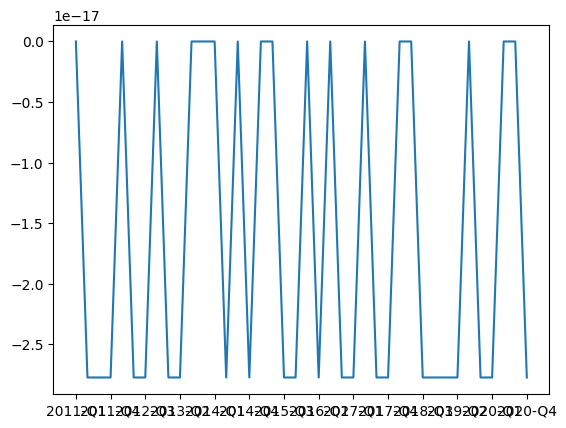

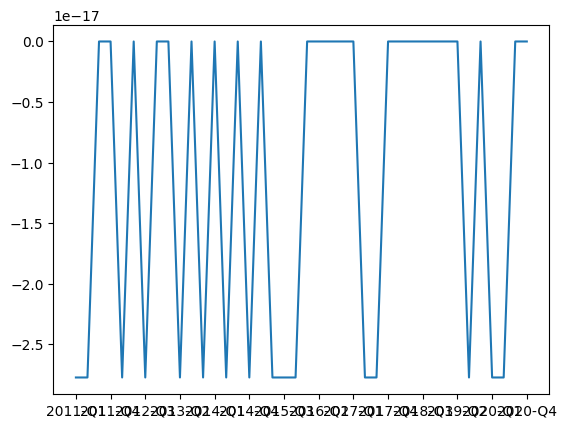

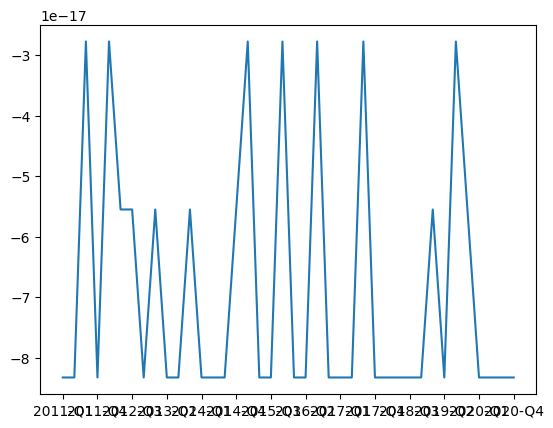

In [26]:
# The next step is to calculate the `classic` task content intensity, i.e.
# how important is a particular general task content category in the workforce
# Here, we're looking at non-routine cognitive analytical tasks, as defined
# by David Autor and Darron Acemoglu:



combined["Belgium_NRCA"] = combined["std_Belgium_t_4A2a4"] + combined["std_Belgium_t_4A2b2"] + combined["std_Belgium_t_4A4a1"]
combined["Poland_NRCA"] = combined["std_Poland_t_4A2a4"] + combined["std_Poland_t_4A2b2"] + combined["std_Poland_t_4A4a1"]
combined["Spain_NRCA"] = combined["std_Spain_t_4A2a4"] + combined["std_Spain_t_4A2b2"] + combined["std_Spain_t_4A4a1"]

# And we standardise NRCA in a similar way.

standarlized(combined,"Belgium_NRCA", "share_Belgium")
standarlized(combined,"Poland_NRCA", "share_Poland")
standarlized(combined,"Spain_NRCA", "share_Spain")
#print(combined["std_Spain_NRCA"])

# Finally, to track the changes over time, we have to calculate a country-level mean
# Step 1: multiply the value by the share of such workers.
combined["multip_Spain_NRCA"] = combined["std_Spain_NRCA"] * combined["share_Spain"]
combined["multip_Belgium_NRCA"] = combined["std_Belgium_NRCA"] * combined["share_Belgium"]
combined["multip_Poland_NRCA"] = combined["std_Poland_NRCA"] * combined["share_Poland"]

# Step 2: sum it up (it basically becomes another weighted mean)

agg_Spain = combined.groupby(["TIME"])["multip_Spain_NRCA"].sum().reset_index()
agg_Belgium = combined.groupby(["TIME"])["multip_Belgium_NRCA"].sum().reset_index()
agg_Poland = combined.groupby(["TIME"])["multip_Poland_NRCA"].sum().reset_index()

# We can plot it now!

plt.plot(agg_Poland["TIME"], agg_Poland["multip_Poland_NRCA"])
plt.xticks(range(0, len(agg_Poland), 3), agg_Poland["TIME"][::3])
plt.show()

plt.plot(agg_Spain["TIME"], agg_Spain["multip_Spain_NRCA"])
plt.xticks(range(0, len(agg_Spain), 3), agg_Spain["TIME"][::3])
plt.show()

plt.plot(agg_Belgium["TIME"], agg_Belgium["multip_Belgium_NRCA"])
plt.xticks(range(0, len(agg_Belgium), 3), agg_Belgium["TIME"][::3])
plt.show()

# If this code gets automated and cleaned properly,
#  you should be able to easily add other countries as well as other tasks.
# E.g.:

# Routine manual
# 4.A.3.a.3	Controlling Machines and Processes
# 4.C.2.d.1.i	Spend Time Making Repetitive Motions
# 4.C.3.d.3	Pace Determined by Speed of Equipment
